<a href="https://colab.research.google.com/github/Andreas-Lukito/Medzy_ocr/blob/main/medzy_colab_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Andreas-Lukito/Medzy_ocr/blob/main/medzy_collab_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medzy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Overview

This project aims to develop a machine learning model capable of interpreting doctors’ handwriting on prescriptions. By accurately detecting and translating challenging handwriting, the model will empower patients to read their prescriptions independently, making it easier for them to purchase their medications without confusion if they run out of medecine or to check if the cleric gave the correct medicine.

This model will use Tensor flows' keras convolutional neural network as reference to this <a href = "https://www.tensorflow.org/tutorials/images/cnn">documentation</a>. The model will also be trained using this <a href="https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset">dataset</a> from kaggle.

## Importing needed libraries

### Installing environment

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [3]:
# basic python libraries
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import numpy as np
import os
import glob

# data preprocessing libraries
from sklearn.preprocessing import LabelEncoder

# tensor flow libraries
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Fine tuning libraries
import keras_tuner

## GPU Setup

This section of the code is contributed by <a href = "https://github.com/SonicRay241">Rayhan Permana</a>

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
#check if gpu is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing the Data

### Train data

#### Train Labels

In [6]:
train_path = "/content/drive/MyDrive/project_medzy/dataset/Training"
train_labels = pd.read_csv(os.path.join(train_path,"training_labels.csv"), delimiter = ",")

In [7]:
train_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [8]:
medicine_enc = LabelEncoder()
train_name_enc = to_categorical(medicine_enc.fit_transform(train_labels["MEDICINE_NAME"]), num_classes=78)
# train_labels["MEDICINE_NAME_ENC"] = train_name_enc

In [9]:
len(train_labels["MEDICINE_NAME"].unique())

78

after encoding there are 78 unique values/medicines since we are using label encoder, we will put them all in to a seperate column

#### Train Images

In [10]:
#the image width and height to pass to the model
img_width = 420
img_height = np.round(img_width/3, 0).astype("int")

# batch size to reduce memory usage (and improve numa node usage)
batch_size = 128

In [11]:
train_images = []
train_files = glob.glob("/content/drive/MyDrive/project_medzy/dataset/Training/training_words/*.png")
for picture in train_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)


    train_images.append(image)
    # image = np.asarray(image) # for numpy 1.23

    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

train_images = np.array(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

# Shuffling the data
BUFFER_SIZE = len(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

train_dataset = train_dataset.batch(batch_size)

In [12]:
print("Dataset shape:", train_images[0].shape)
print("Labels shape:", train_labels.shape)

Dataset shape: (140, 420)
Labels shape: (3120, 3)


##### Check if it is correct

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 187, 187, 193],
       [255, 255, 255, ..., 219, 214, 216],
       [255, 255, 255, ..., 233, 236, 238]], dtype=uint8)
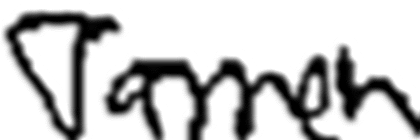

In [13]:
train_images[1]

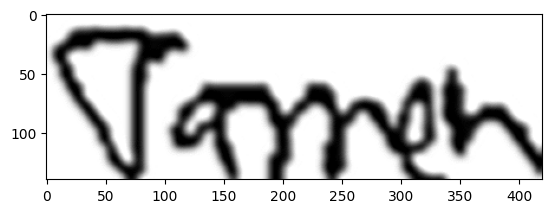

In [14]:
plt.imshow(train_images[1], cmap = "gray")

In [15]:
print("Example label:", train_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


### Validation data

#### validation Labels

In [16]:
validation_path = "/content/drive/MyDrive/project_medzy/dataset/Validation"
validation_labels = pd.read_csv(os.path.join(validation_path,"validation_labels.csv"), delimiter = ",")

In [17]:
validation_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [18]:
validation_name_enc = to_categorical(medicine_enc.transform(validation_labels["MEDICINE_NAME"]), num_classes=78)
# validation_labels["MEDECINE_NAME_ENC"] = validation_name_enc

In [19]:
type(validation_name_enc)

numpy.ndarray

In [20]:
len(validation_labels["MEDICINE_NAME"].unique())

78

#### Validation Images

In [21]:
validation_images = []
validation_files = glob.glob("/content/drive/MyDrive/project_medzy/dataset/Validation/validation_words/*.png")
for picture in validation_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)

    validation_images.append(image)
    # image = np.asarray(image) # for numpy 1.23

    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

validation_images = np.array(validation_images)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

validation_dataset = validation_dataset.batch(batch_size)

In [22]:
print("Dataset shape:", validation_images.shape)
print("Labels shape:", validation_labels.shape)

Dataset shape: (780, 140, 420)
Labels shape: (780, 3)


##### Check if it is correct

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
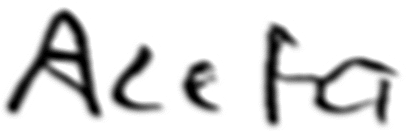

In [23]:
validation_images[0]

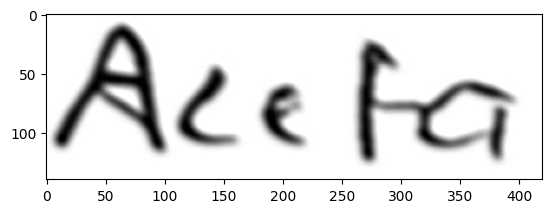

In [24]:
plt.imshow(validation_images[0], cmap = "gray")

In [25]:
print("Example label:", validation_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


### Test data

#### Test Labels

In [26]:
test_path = "/content/drive/MyDrive/project_medzy/dataset/Testing"
test_labels = pd.read_csv(os.path.join(test_path,"testing_labels.csv"), delimiter = ",")

In [27]:
test_labels.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


##### Encode the medecine name

In [28]:
test_name_enc = to_categorical(medicine_enc.transform(test_labels["MEDICINE_NAME"]), num_classes=78)
# test_labels["train_medecine_name_enc"] = test_name_enc

In [29]:
len(test_labels["MEDICINE_NAME"].unique())

78

#### Testing Images

In [30]:
test_images = []
test_files = glob.glob("/content/drive/MyDrive/project_medzy/dataset/Testing/testing_words/*.png")
for picture in test_files:
    image = cv2.resize(cv2.imread(picture, cv2.IMREAD_GRAYSCALE), (img_width, img_height))

    #since cv2 sometimes return a "none" type we will append the data after validating it if it is a not "none" type
    if image is None:
        print(f"Err importing picture {picture}")
        continue
    #apply adaptive treshold
    image = cv2.adaptiveThreshold(image,
                                         255, # the max value
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, #the treshold we are using
                                         41, #how many pixels to look at
                                         10 #noise reduction
                                         )

    #sharpening the image
    # Create the sharpening kernel
    kernel = np.array([[-1, -1, 1],
                        [-1,  8, -1],
                        [-1, -2, -1]])

    #increase the contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(7,7))
    image = clahe.apply(image)

    #blur the image so that the lines are more defined
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)
    image = cv2.GaussianBlur(image, (7,7), 20)

    # Sharpen the image
    image = cv2.filter2D(image, -1, kernel)

    test_images.append(image)
    # image = np.asarray(image) # for numpy 1.23

    # To show the images
    # plt.imshow(image, cmap = "gray")
    # plt.show()

test_images = np.array(test_images)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [31]:
print("Dataset shape:", test_images.shape)
print("Labels shape:", test_labels.shape)

Dataset shape: (780, 140, 420)
Labels shape: (780, 3)


##### Check if it is correct

In [32]:
test_images[0].shape

(140, 420)

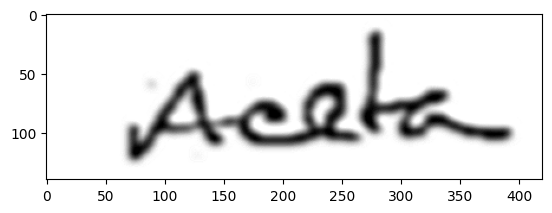

In [33]:
plt.imshow(test_images[0], cmap = "gray")

In [34]:
print("Example label:", test_labels.iloc[0])

Example label: IMAGE                  0.png
MEDICINE_NAME          Aceta
GENERIC_NAME     Paracetamol
Name: 0, dtype: object


## Building the artificial neural network

#### Make a model create function

##### Parameters for the model

In [35]:
#number of classes to determine how many neurons are in the output layer
num_classes = len(train_labels["MEDICINE_NAME"].unique())
num_classes

78

In [36]:
#the image size to determine the shape for the convolutional neural network to scan
train_images[0].shape

(140, 420)

In [47]:
#make everything to int 32 since there is a type error
train_images = train_images.astype("float16")
train_name_enc = train_name_enc.astype("float16")
validation_images = validation_images.astype("float16")
validation_name_enc = validation_name_enc.astype("float16")
test_images = test_images.astype("float16")
test_name_enc = test_name_enc.astype("float16")

#### Custom metrics

In [48]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return keras.backend.cast(recall, "float16")

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return keras.backend.cast(precision, "float16")

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return keras.backend.cast(f1, "float16")

def accuracy(y_true, y_pred):
    correct_predictions = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_samples = K.sum(K.round(K.clip(y_true, 0, 1)))
    acc = correct_predictions / (total_samples + K.epsilon())
    return keras.backend.cast(acc, "float16")

#### Create a model builder for gridsearch

the even filter shapes aren't recommended because it lacks the ability to devide the previous layer pixels arould the output pixel <a hre = "https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15">(Pandey, 2020)</a>.

<a href = "https://medium.com/@nerdjock/convolutional-neural-network-lesson-9-activation-functions-in-cnns-57def9c6e759">Machine Learning in Plain English (2023)</a> The most common activation functions are "relu" and "leaky relu" therefore we would pass it in the grid search.

Max pooling excells in image classification, due to how max pooling captures the most prominent features and reduce the variance of the input <a href = "https://www.linkedin.com/advice/1/how-do-you-choose-appropriate-pooling-method-2uvmc#adaptive-pooling">(Awad et. al, n.d.)</a>.

In [49]:
def create_model(hp):
    input_shape = (img_height, img_width, 1)
    model = Sequential()
    metrics = [accuracy, recall_m, precision_m, f1_score]

    # Convert NumPy types to standard Python types
    filter_choice = [int(32), int(64), int(128)]
    kernel_size_choice = [int(3), int(5), int(7)]
    n_neurons_choice = [int(256), int(512), int(1024)]
    learning_rate_choice = [float(0.0001), float(0.001), float(0.01)]

    # Input layer
    model.add(layers.Conv2D(
        filters=hp.Choice("input_filter", filter_choice),
        kernel_size=hp.Choice("input_kernel_size", kernel_size_choice),
        activation=hp.Choice("input_activation", ["relu", "leaky_relu"]),
        input_shape=input_shape
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

    # Convolutional layers
    for i in range(hp.Choice("n_conv_layers", [int(1), int(3)])):
        model.add(layers.Conv2D(
            filters=hp.Choice(f"conv_filter_{i}", filter_choice),
            kernel_size=hp.Choice(f"conv_kernel_size_{i}", kernel_size_choice),
            activation=hp.Choice(f"conv_activation_{i}", ["relu", "leaky_relu"])
        ))
        if i < 1:
            model.add(layers.MaxPooling2D(pool_size=2))

    # Flatten layer
    model.add(layers.Flatten())

    # Intermediate dense layer
    model.add(layers.Dense(
        hp.Choice(f"n_neurons_dense_{i}", n_neurons_choice),
        activation=hp.Choice(f"dense_activation{i}", ["relu", "leaky_relu"])
    ))

    # Output layer (78 classes)
    model.add(layers.Dense(78, activation="softmax"))

    # Optimizer selection
    optimizer_name = hp.Choice('optimizer', ['adamw', 'sgd', 'rmsprop'])
    if optimizer_name == 'adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=hp.Choice('learning_rate', learning_rate_choice), weight_decay=1e-5)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', learning_rate_choice))
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', learning_rate_choice))

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)

    return model

In this project, a hyperband gridsearch will be used since the hyperband tuner will stop training the model if the accuracy is low on the validation data <a href = "https://medium.com/analytics-vidhya/automated-hyperparameter-tuning-with-keras-tuner-and-tensorflow-2-0-31ec83f08a62#:~:text=Overview%20of%20available%20Keras%20Tuners,Tuners%20available%2C%20as%20of%20now.&text=The%20basic%20and%20least%20efficient,from%20a%20search%20space%20randomly.&text=A%20Hyperband%20tuner%20is%20an,accuracy%20on%20the%20validation%20set.&text=Bayesian%20Optimization%20works%20the%20same,Keras%20Tuner%20with%20the%20Documentation.">(Bag, 2021)</a>. Type casting will be applied since there was an error that kept occuring which is "TypeError: Object of type int64 is not JSON serializable" likeley due to keras_tuner trying to save the paramaeters in a JSON file and jason dosen't support int 64 can be refered <a href = "https://developers.google.com/discovery/v1/type-format#:~:text=For%20example%2C%20a%2064-bit,string%20in%20JSON%20requests%2Fresponses.">here</a>.

In [50]:
#tuner_hyperband = keras_tuner.Hyperband(
#     hypermodel = create_model,
#     objective= keras_tuner.Objective("val_recall",
#                                      direction='max'),
#     max_epochs=100,
#     factor = 5,
#     hyperband_iterations=1, #the number of itterations that the model will go trough the hyperband algorithm
#     seed = 42, #for reproducibility
#     overwrite = True,
#     # directory = "model_train_log", #to store logs on the trial results
#     # project_name = "medzy"
#)

In [51]:
 # Bayesian optimization
tuner_bayes = keras_tuner.BayesianOptimization(
   hypermodel = create_model,
   objective= "val_recall",
   max_trials = int(2000), #ther are so many combinations
   seed = 42,
   overwrite = True
)

In [52]:
#tuner_gridSearch = keras_tuner.GridSearch(
#    hypermodel = create_model,
#    objective = keras_tuner.Objective("val_recall",
#                                     direction='max'),
#    seed = 42,
#    overwrite = True
#)

#### Start the grid search

In [53]:
validation_steps = int(len(validation_images)) #the number of validation for number of batches

tuner_bayes.search(
    train_images,
    train_name_enc,
    epochs = int(50),
    validation_data = (validation_images, validation_name_enc), #data used to evaluate the model after each epoch
    validation_steps = validation_steps, #number of batches used for validation
    callbacks = [
              #keras.callbacks.EarlyStopping(
    #         monitor="val_recall_m",  # Metric to monitor
    #         patience=3,  # Number of epochs with no improvement before stopping
    #         mode="min",  # Since we want to maximize recall
    #         # restore_best_weights=True,  # Restores the best model weights at the end
    #         verbose=1  # Prints when early stopping happens
    #         ),
            keras.callbacks.EarlyStopping(
                monitor = "val_f1_score",
                patience = int(3),
                mode = "max",
                restore_best_weights = True,
                verbose = int(1)
            )
            # keras.callbacks.EarlyStopping(
            #     monitor = "val_precision",
            #     patience = 3,
            #     mode = "max",
            #     restore_best_weights = True,
            #     verbose = 1
            # )
           ]
)

Trial 2 Complete [00h 00m 55s]

Best val_recall So Far: None
Total elapsed time: 00h 02m 16s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |64                |input_filter
5                 |3                 |input_kernel_size
relu              |relu              |input_activation
1                 |1                 |n_conv_layers
128               |128               |conv_filter_0
7                 |5                 |conv_kernel_size_0
leaky_relu        |leaky_relu        |conv_activation_0
256               |256               |n_neurons_dense_0
relu              |relu              |dense_activation0
adamw             |adamw             |optimizer
0.01              |0.01              |learning_rate
64                |None              |conv_filter_1
5                 |None              |conv_kernel_size_1
leaky_relu        |None              |conv_activation_1
128               |None              |conv_filter_2
3                 |

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 237, in _build_and_fit_model
    utils.save_json(
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/utils.py", line 91, in save_json
    obj_str = json.dumps(obj)
              ^^^

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 237, in _build_and_fit_model
    utils.save_json(
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/utils.py", line 91, in save_json
    obj_str = json.dumps(obj)
              ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/json/encoder.py", line 200, in encode
    chunks = self.iterencode(o, _one_shot=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/json/encoder.py", line 258, in iterencode
    return _iterencode(o, 0)
           ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/json/encoder.py", line 180, in default
    raise TypeError(f'Object of type {o.__class__.__name__} '
TypeError: Object of type int64 is not JSON serializable


In [ ]:
best_hp = tuner_bayes.get_best_hyperparameters()[0]
best_hp.values